![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/Spark_NLP_Udemy_MOOC/Open_Source/32.01.ImageAssembler.ipynb)

# **ImageAssembler**

This notebook will cover the different parameters and usages of `ImageAssembler`. This annotator provides the ability to prepares image data read by Spark into a format that is processable by Spark NLP.

**📖 Learning Objectives:**

1. Get an introduction to image-related tasks in Spark NLP.

2. Understand when to use the `ImageAssembler`.

3. Understand the output of the `ImageAssembler`.


**🔗 Helpful Links:**

- Documentation : [ImageAssembler](https://nlp.johnsnowlabs.com/docs/en/annotators#imageassembler)

- Python Docs : [ImageAssembler](https://nlp.johnsnowlabs.com/api/python/reference/autosummary/sparknlp/base/image_assembler/index.html)

- Scala Docs : [ImageAssembler](https://nlp.johnsnowlabs.com/api/com/johnsnowlabs/nlp/annotators/RegexTokenizer.html)

- For extended examples of usage, see the [Spark NLP Workshop repository](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Public/).

## **📜 Background**


With the arrival of the Vision Transformer (ViT), Spark NLP brought support to image-related tasks by introducing a new annotator to process image data: the `ImageAssembler`. It is mandatory to use when processing images and is the entry point for Spark NLP pipelines. It can be thought of the equivalent of the `DocumentAssembler` in the text processing space.

## **🎬 Colab Setup**

In [1]:
!pip install -q pyspark==3.1.2 spark-nlp==4.2.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 MB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.4/448.4 KB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 KB 14.5 MB/s eta 0:00:00


In [2]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline
from pyspark.sql import functions as F

spark = sparknlp.start()

## **🖨️ Input/Output Annotation Types**

- Input: `NONE`

- Output: `IMAGE`

## **🔎 Dive-In**


### Download Images

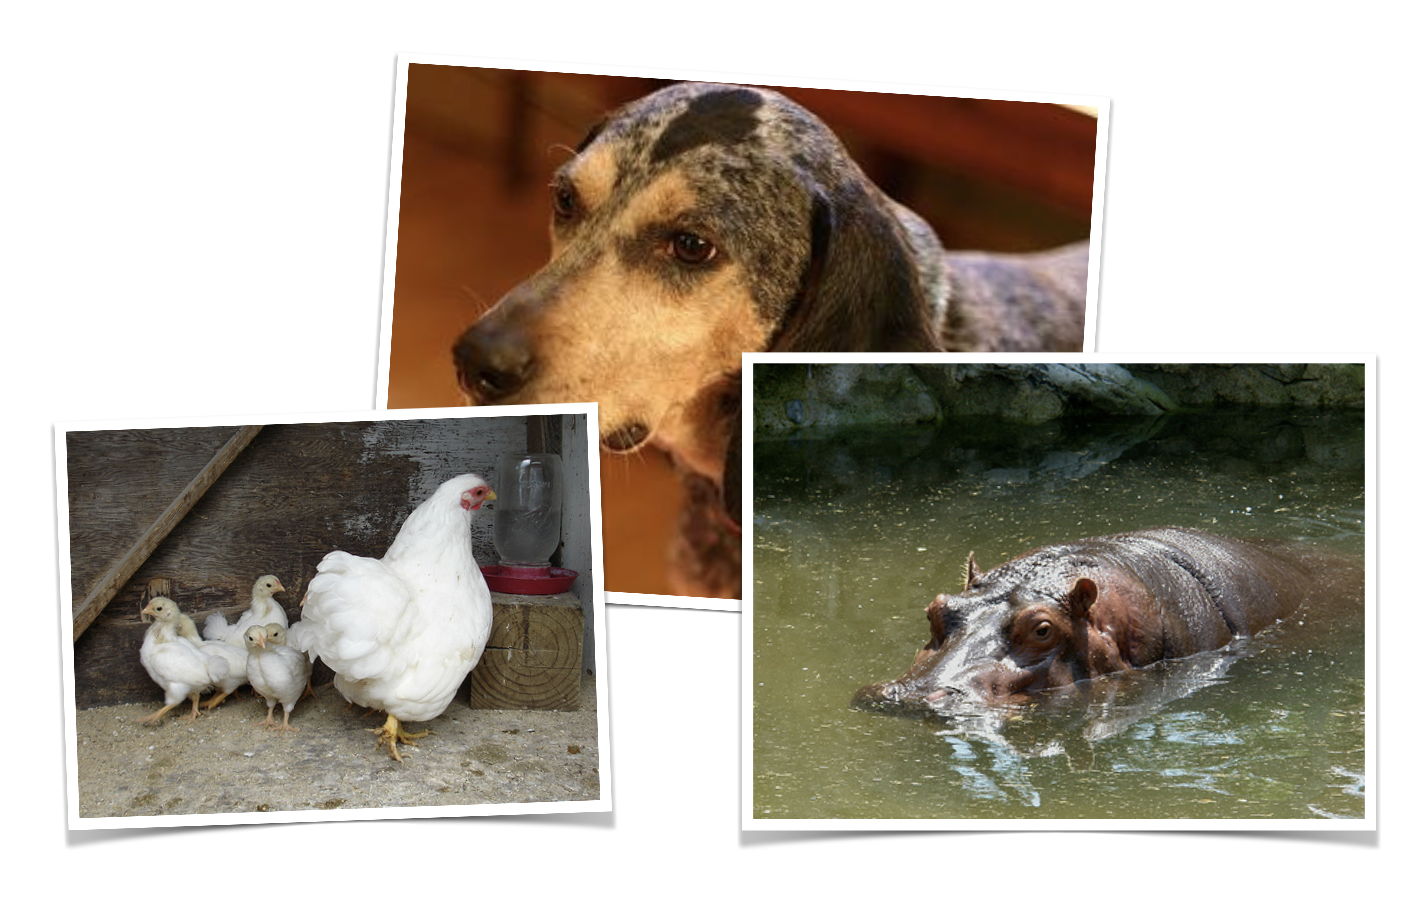

In [18]:
!wget -q https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/images/images.zip

In [4]:
import shutil
shutil.unpack_archive("images.zip", "images", "zip")

In [5]:
!ls images/images/

bluetick.jpg   egyptian_cat.jpeg  hippopotamus.JPEG  ostrich.JPEG  palace.JPEG
chihuahua.jpg  hen.JPEG		  junco.JPEG	     ox.JPEG	   tractor.JPEG


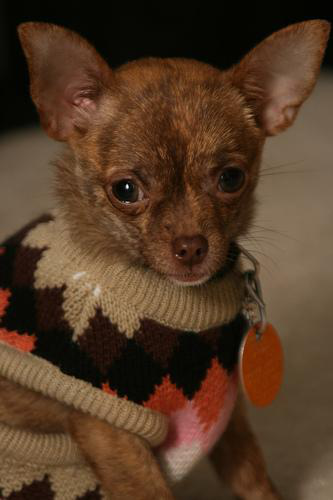

In [19]:
from IPython.display import display
from PIL import Image

path="images/images/chihuahua.jpg"
display(Image.open(path))

### Read and Process Images in Pipeline

In [20]:
data_df = spark.read.format("image").option("dropInvalid", value = True).load(path="./images/images/")

In [21]:
image_assembler = ImageAssembler() \
    .setInputCol("image") \
    .setOutputCol("image_assembler")

pipeline = Pipeline(stages=[image_assembler])

image_df = pipeline.fit(data_df).transform(data_df)

In [22]:
image_df.show(truncate=40)

+----------------------------------------+----------------------------------------+
|                                   image|                         image_assembler|
+----------------------------------------+----------------------------------------+
|{file:///content/images/images/palace...|[{image, file:///content/images/image...|
|{file:///content/images/images/egypti...|[{image, file:///content/images/image...|
|{file:///content/images/images/hippop...|[{image, file:///content/images/image...|
|{file:///content/images/images/hen.JP...|[{image, file:///content/images/image...|
|{file:///content/images/images/ostric...|[{image, file:///content/images/image...|
|{file:///content/images/images/junco....|[{image, file:///content/images/image...|
|{file:///content/images/images/blueti...|[{image, file:///content/images/image...|
|{file:///content/images/images/chihua...|[{image, file:///content/images/image...|
|{file:///content/images/images/tracto...|[{image, file:///content/images/im

In [23]:
image_df.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)
 |-- image_assembler: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- origin: string (nullable = true)
 |    |    |-- height: integer (nullable = false)
 |    |    |-- width: integer (nullable = false)
 |    |    |-- nChannels: integer (nullable = false)
 |    |    |-- mode: integer (nullable = false)
 |    |    |-- result: binary (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: string (valueContainsNull = true)



We can check the information that this new column stores.

In [24]:
image_df.select(F.explode(F.arrays_zip(image_df.image_assembler.annotatorType,
                                       image_df.image_assembler.origin,
                                       image_df.image_assembler.height,
                                       image_df.image_assembler.width,
                                       image_df.image_assembler.nChannels,
                                       image_df.image_assembler.mode,
                                       image_df.image_assembler.result,
                                       image_df.image_assembler.metadata)).alias("cols"))\
        .select(F.expr("cols['0']").alias("annotatorType"),
                F.expr("cols['1']").alias("origin"),
                F.expr("cols['2']").alias("height"),
                F.expr("cols['3']").alias("width"),
                F.expr("cols['4']").alias("nChannels"),
                F.expr("cols['5']").alias("mode"),
                F.expr("cols['6']").alias("result"),
                F.expr("cols['7']").alias("metadata"),
                                       ).show(truncate=20)

+-------------+--------------------+------+-----+---------+----+--------------------+------------+
|annotatorType|              origin|height|width|nChannels|mode|              result|    metadata|
+-------------+--------------------+------+-----+---------+----+--------------------+------------+
|        image|file:///content/i...|   334|  500|        3|  16|[22 5E 6E 09 49 5...|{image -> 0}|
|        image|file:///content/i...|   480|  640|        3|  16|[38 19 8C 43 19 9...|{image -> 0}|
|        image|file:///content/i...|   333|  500|        3|  16|[84 7E 6B 81 7D 6...|{image -> 0}|
|        image|file:///content/i...|   375|  500|        3|  16|[3D 4B 47 3D 47 4...|{image -> 0}|
|        image|file:///content/i...|   400|  300|        3|  16|[0E 09 06 07 06 0...|{image -> 0}|
|        image|file:///content/i...|   446|  500|        3|  16|[CB C6 C3 CC C7 C...|{image -> 0}|
|        image|file:///content/i...|   500|  333|        3|  16|[04 2B 57 04 2B 5...|{image -> 0}|
|        i

### Usage of ImageAssembler

The `ImageAssembler` can be used in a pipeline with the Vision Transformer (ViT) model.

In [25]:
image_assembler = ImageAssembler() \
    .setInputCol("image") \
    .setOutputCol("image_assembler")

image_classifier = ViTForImageClassification \
    .pretrained() \
    .setInputCols("image_assembler") \
    .setOutputCol("classes")

pipeline = Pipeline(
    stages=[
        image_assembler,
        image_classifier,
])

image_df = pipeline.fit(data_df).transform(data_df)

image_classifier_vit_base_patch16_224 download started this may take some time.
Approximate size to download 309.7 MB
[OK!]


In [26]:
image_df.show(truncate=40)

+----------------------------------------+----------------------------------------+----------------------------------------+
|                                   image|                         image_assembler|                                 classes|
+----------------------------------------+----------------------------------------+----------------------------------------+
|{file:///content/images/images/palace...|[{image, file:///content/images/image...|[{category, 0, 5, palace, {nChannels ...|
|{file:///content/images/images/egypti...|[{image, file:///content/images/image...|[{category, 0, 11, Egyptian cat, {nCh...|
|{file:///content/images/images/hippop...|[{image, file:///content/images/image...|[{category, 0, 55, hippopotamus, hipp...|
|{file:///content/images/images/hen.JP...|[{image, file:///content/images/image...|[{category, 0, 2, hen, {nChannels -> ...|
|{file:///content/images/images/ostric...|[{image, file:///content/images/image...|[{category, 0, 24, ostrich, Struthio ...|


We can check the predicted classes of each image.

In [27]:
image_df.select(F.explode(F.arrays_zip(image_df.classes.metadata, 
                                       image_df.classes.result)).alias("cols"))\
        .select(F.expr("cols['0']['origin']").alias("images"),
                F.expr("cols['0']['width']").alias("width"),
                F.expr("cols['0']['height']").alias("height"),
                F.expr("cols['1']").alias("class")).show(truncate=False)

+-----------------------------------------------+-----+------+--------------------------------------------------------+
|images                                         |width|height|class                                                   |
+-----------------------------------------------+-----+------+--------------------------------------------------------+
|file:///content/images/images/palace.JPEG      |500  |334   |palace                                                  |
|file:///content/images/images/egyptian_cat.jpeg|640  |480   |Egyptian cat                                            |
|file:///content/images/images/hippopotamus.JPEG|500  |333   |hippopotamus, hippo, river horse, Hippopotamus amphibius|
|file:///content/images/images/hen.JPEG         |500  |375   |hen                                                     |
|file:///content/images/images/ostrich.JPEG     |300  |400   |ostrich, Struthio camelus                               |
|file:///content/images/images/junco.JPE

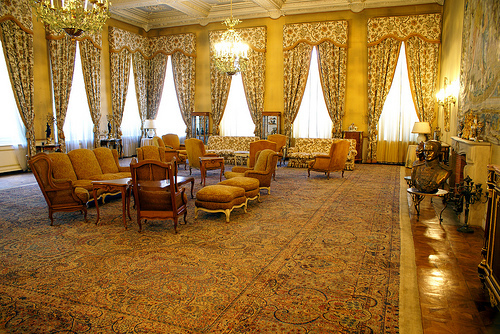

In [28]:
path="images/images/palace.JPEG"
display(Image.open(path))